<a href="https://colab.research.google.com/github/Dangvinh777/dataticket/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🛠️ SETUP

In [1]:
    # Cài đặt các thư viện
    !pip install --quiet backtesting ta
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime
    import seaborn as sns
    from IPython.display import display
    from backtesting import Backtest, Strategy
    from ta.trend import sma_indicator
    from ta.trend import ema_indicator
    from matplotlib import pyplot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


# 💻 STRATEGY

**Chiến thuật MACD (Moving Average Convergence Divergence) với EMA:**

1. Sử dụng hai EMA, EMA(n1) và EMA(n2), với n1 < n2.
2. Tính toán MACD bằng cách lấy EMA(n1) trừ EMA(n2).
3. Tính toán một EMA khác (thường được gọi là "tín hiệu" EMA) trên MACD.
4. Khi MACD vượt qua EMA tín hiệu từ dưới lên, đây được coi là tín hiệu mua.
5. Khi MACD cắt xuống EMA tín hiệu từ trên xuống, đây được coi là tín hiệu bán.

Thường được sử dụng để xác định điểm mua vào (buy) hoặc bán ra (sell) trong một xu hướng tăng.

### Nhập data

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/Dangvinh777/dataticket/main/hag.csv")
df.head(6)

,date,open,high,low,close,volume
0,2008-12-22,13.25,14.13,13.25,14.13,2830
1,2008-12-23,14.72,14.72,14.72,14.71,3010
2,2008-12-24,15.45,15.45,15.45,15.45,1000
3,2008-12-25,16.19,16.19,16.19,16.19,156010
4,2008-12-26,16.93,16.93,16.48,16.92,304910
5,2008-12-29,17.66,17.66,17.66,17.66,84900


## 🌟 Fundamental Analysis ✅

In [11]:
fa_df=pd.read_csv("https://raw.githubusercontent.com/Dangvinh777/dataticket/main/hag_fundamentals.csv")
fa_df.head(6)
fa_df = fa_df[fa_df['quarter'] == 1]
df=pd.read_csv("https://raw.githubusercontent.com/Dangvinh777/dataticket/main/hag.csv")
# Điều chỉnh tên nhằm mục đích dùng được hàm stats Backtest
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# Change data type of "date" from string to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [12]:
fa_df

,ticker,year,quarter,lt_trade_receivables,gross_profit,st_liabilities,fin_leased_fixed_assets,cashneq,st_trade_accounts_payable,eps,...,taxes_n_other_receivables_to_gov,casheq,other_receipts_from_operation,changes_in_prepaid_exps,olt_invest,owners_cap,collections_on_invest_in_oe,dividends_paid_to_owners,dividends_n_interest_n_profit_received,changes_in_payables
3,hag,2018,1,NaN,4.790731e+11,1.184304e+13,NaN,1.073201e+11,1.141691e+12,3.0,...,7.884029e+09,NaN,NaN,-1.818112e+11,NaN,9.274679e+12,2.550000e+09,NaN,4.889223e+10,-1.593795e+12
8,hag,2017,1,NaN,2.189235e+11,1.183126e+13,NaN,2.092952e+11,1.492604e+12,7.0,...,5.424444e+09,NaN,NaN,-6.424086e+10,NaN,7.899679e+12,NaN,NaN,1.062454e+10,1.596706e+11
13,hag,2016,1,NaN,2.955014e+11,1.456349e+13,NaN,1.719734e+12,1.088812e+12,88.0,...,1.754211e+09,5.524810e+11,NaN,-3.189016e+10,NaN,7.899679e+12,2.554688e+11,NaN,4.927405e+10,7.172443e+09
18,hag,2015,1,NaN,4.334503e+11,1.189617e+13,NaN,9.326983e+11,1.861152e+12,462.0,...,8.875839e+09,NaN,NaN,7.303657e+10,NaN,7.899679e+12,6.000000e+08,NaN,1.494755e+10,8.797403e+11
23,hag,2014,1,NaN,4.310164e+11,4.569077e+12,NaN,1.429107e+12,7.069019e+11,NaN,...,1.287710e+10,NaN,NaN,-8.963460e+10,8.204445e+11,7.181547e+12,1.805340e+11,NaN,1.603384e+10,1.911929e+11
28,hag,2013,1,NaN,3.395080e+11,7.849657e+12,1.273925e+10,2.444249e+12,6.155525e+11,NaN,...,3.688857e+09,7.706474e+11,NaN,-2.774166e+09,2.571948e+12,5.373710e+12,3.000000e+11,NaN,1.382594e+10,3.269532e+11
33,hag,2012,1,NaN,2.518117e+11,7.185618e+12,1.638662e+10,1.687407e+12,9.299657e+11,NaN,...,3.107490e+08,NaN,NaN,-5.641917e+10,3.582774e+12,4.672806e+12,NaN,NaN,7.383081e+10,2.326395e+11
38,hag,2011,1,NaN,3.436949e+11,6.715118e+12,1.518326e+10,2.489107e+12,6.505612e+11,875000.0,...,2.800103e+10,NaN,NaN,-7.023924e+09,3.088612e+12,4.672806e+12,2.000000e+11,NaN,7.491024e+10,1.667831e+11
43,hag,2010,1,NaN,6.164430e+11,4.489259e+12,NaN,1.345534e+12,1.710660e+11,1887000.0,...,5.523660e+09,NaN,NaN,NaN,1.716631e+12,2.704655e+12,NaN,NaN,NaN,NaN
48,hag,2009,1,NaN,4.790074e+11,2.554936e+12,NaN,4.562434e+11,2.163517e+11,NaN,...,3.054390e+08,NaN,NaN,NaN,2.163554e+12,1.798145e+12,NaN,NaN,NaN,NaN


In [13]:
df_columns = fa_df.columns.tolist()
print(df_columns)

['ticker', 'year', 'quarter', 'lt_trade_receivables', 'gross_profit', 'st_liabilities', 'fin_leased_fixed_assets', 'cashneq', 'st_trade_accounts_payable', 'eps', 'changes_in_sale_securities', 'invest_in_oe', 'st_trade_accounts_receivable', 'lt_trade_payables', 'repaym_of_fin_leases', 'lt_advances_from_customers', 'st_advances_from_customers', 'share_of_associates_n_joint_ventures_result', 'profit_before_tax', 'st_invest', 'interest_paid', 'net_cf_from_operation', 'st_loan_receivables', 'lt_provision_for_invest', 'pnl_from_invest', 'share_premium', 'allocation_of_goodwill', 'olt_liabilities', 'eat_of_parent_company', 'ebt', 'operating_profit', 'interest_income_n_dividends', 'changes_in_inventories', 'inventories', 'preferred_stock', 'receipts_from_disposal_of_fixed_assets_n_olt_assets', 'receipts_from_equity_issue_n_cap_contri', 'fin_income', 'invest_in_associates_or_joint_ventures', 'st_assets', 'provisions', 'deferred_tax_exps', 'invest_in_subsidiaries', 'fixed_assets', 'st_provision_

In [14]:
#Sắp xếp các hàng trong DataFrame fun_df theo thứ tự tăng dần của cột year
#Sau đó chỉ giữ lại các cột year, profit_before_tax, curr_tax_exps, và owners_equity
fa_df.sort_values(by='year')[['year', 'profit_before_tax', 'curr_tax_exps', 'owners_equity']]

,year,profit_before_tax,curr_tax_exps,owners_equity
48,2009,NaN,7.213250e+08,3.692305e+12
43,2010,NaN,4.739918e+10,5.137058e+12
38,2011,NaN,1.767062e+11,8.909467e+12
33,2012,9.862628e+10,6.220446e+10,9.486043e+12
28,2013,1.074604e+11,2.096985e+10,9.962345e+12
23,2014,3.991204e+11,8.093615e+09,1.322342e+13
18,2015,4.403188e+11,7.035636e+10,1.479823e+13
13,2016,8.713216e+10,1.261704e+10,1.806027e+13
8,2017,8.480943e+09,1.883774e+10,1.637503e+13
3,2018,3.240423e+10,1.154370e+08,1.828468e+13


In [15]:
tmp = fa_df.sort_values(by='year')[['year', 'profit_before_tax', 'curr_tax_exps', 'owners_equity']]
tmp['ROE'] = (tmp['profit_before_tax'] - tmp['curr_tax_exps']) / tmp['owners_equity']
# tmp['Date'] = pd.to_datetime(tmp['year'] + 1, format='%Y')
tmp

,year,profit_before_tax,curr_tax_exps,owners_equity,ROE
48,2009,NaN,7.213250e+08,3.692305e+12,NaN
43,2010,NaN,4.739918e+10,5.137058e+12,NaN
38,2011,NaN,1.767062e+11,8.909467e+12,NaN
33,2012,9.862628e+10,6.220446e+10,9.486043e+12,0.003840
28,2013,1.074604e+11,2.096985e+10,9.962345e+12,0.008682
23,2014,3.991204e+11,8.093615e+09,1.322342e+13,0.029571
18,2015,4.403188e+11,7.035636e+10,1.479823e+13,0.025000
13,2016,8.713216e+10,1.261704e+10,1.806027e+13,0.004126
8,2017,8.480943e+09,1.883774e+10,1.637503e+13,-0.000632
3,2018,3.240423e+10,1.154370e+08,1.828468e+13,0.001766


Cột ROE là một chỉ số tài chính quan trọng để đo lường khả năng sinh lời của công ty từ tài sản sử dụng. Tính toán giá trị ROE có thể giúp ta đánh giá hiệu quả hoạt động kinh doanh của công ty và so sánh với các công ty khác trong cùng ngành hoặc trên thị trường chung

Chúng ta mua tài sản này nếu ROE năm nay lớn hơn năm trước

LƯU Ý: ROE năm 2011 về trước bị thiếu, giả định rằng nó bằng KHÔNG

In [16]:
#Gán giá trị của các ô trống trong cột ROE của DataFrame tmp bằng 0
tmp['ROE'] = tmp['ROE'].fillna(0)

Việc điền giá trị 0 vào các ô trống trong cột ROE có thể được thực hiện để xử lý các giá trị thiếu (missing values) trong dữ liệu. Nếu không xử lý các giá trị thiếu, các phép tính hoặc phân tích dữ liệu có thể không chính xác hoặc không thực hiện được

In [17]:
#Tạo một cột position và gán giá trị 1 cho các hàng trong DataFrame tmp mà giá trị của cột ROE > giá trị của cột ROE ở hàng trước đó
tmp.loc[tmp['ROE'] > tmp['ROE'].shift(1), 'position'] = 1
#Gán giá trị -1 cho các hàng trong DataFrame tmp mà giá trị của cột ROE nhỏ hơn giá trị của cột ROE ở hàng trước đó
tmp.loc[tmp['ROE'] < tmp['ROE'].shift(1), 'position'] = -1
tmp

,year,profit_before_tax,curr_tax_exps,owners_equity,ROE,position
48,2009,NaN,7.213250e+08,3.692305e+12,0.000000,NaN
43,2010,NaN,4.739918e+10,5.137058e+12,0.000000,NaN
38,2011,NaN,1.767062e+11,8.909467e+12,0.000000,NaN
33,2012,9.862628e+10,6.220446e+10,9.486043e+12,0.003840,1.0
28,2013,1.074604e+11,2.096985e+10,9.962345e+12,0.008682,1.0
23,2014,3.991204e+11,8.093615e+09,1.322342e+13,0.029571,1.0
18,2015,4.403188e+11,7.035636e+10,1.479823e+13,0.025000,-1.0
13,2016,8.713216e+10,1.261704e+10,1.806027e+13,0.004126,-1.0
8,2017,8.480943e+09,1.883774e+10,1.637503e+13,-0.000632,-1.0
3,2018,3.240423e+10,1.154370e+08,1.828468e+13,0.001766,1.0


In [18]:
df['Date'] = df.index
df['year'] = df['Date'].dt.year
df.groupby('year')['Date'].min()

year
2008   2008-12-22
2009   2009-01-02
2010   2010-01-04
2011   2011-01-04
2012   2012-01-03
2013   2013-01-02
2014   2014-01-02
2015   2015-01-05
2016   2016-01-04
2017   2017-01-03
2018   2018-01-02
2019   2019-01-02
2020   2020-01-02
Name: Date, dtype: datetime64[ns]

In [19]:
df['position'] = None
df.loc['2012-01-03', 'position'] = 1
df.loc['2013-01-02', 'position'] = 1
df.loc['2014-01-02', 'position'] = 1
df.loc['2015-01-05', 'position'] =- 1
df.loc['2016-01-04', 'position'] = -1
df.loc['2017-01-03', 'position'] = -1
df.loc['2018-01-02', 'position'] = -1

In [22]:
#@title Backtesting
#Tạo hàm mô phỏng lệnh mua bán theo "position" data ( Một trong những input cơ bản của hàm Backtest)
class GeneralStrategy(Strategy):
    def init(self):
        pass
    def next(self):
        if self.data.position == 1:
            self.buy()
        elif self.data.position == -1:
            self.position.close()

In [23]:

bt = Backtest(
    df,                        # Dữ liệu chứa tín hiệu trading
    GeneralStrategy,           # Hàm thực hiện chiến thuật
    cash=100000,               # Vốn khởi điểm 100000
    commission=0.002,          # Phí 0.002 cho 1 trade xảy ra
    trade_on_close=True,       # Giao dịch vào giá đóng cửa
    exclusive_orders=True      # Giao dịch vào giá đóng cửa
    )
stats = bt.run()

In [24]:
# Thống kê các kết quả
stats.to_frame()

,0
Start,2008-12-22 00:00:00
End,2020-03-18 00:00:00
Duration,4104 days 00:00:00
Exposure Time [%],26.704748
Equity Final [$],168190.85756
Equity Peak [$],203873.81756
Return [%],68.190858
Buy & Hold Return [%],-78.556263
Return (Ann.) [%],4.788822
Volatility (Ann.) [%],19.745125


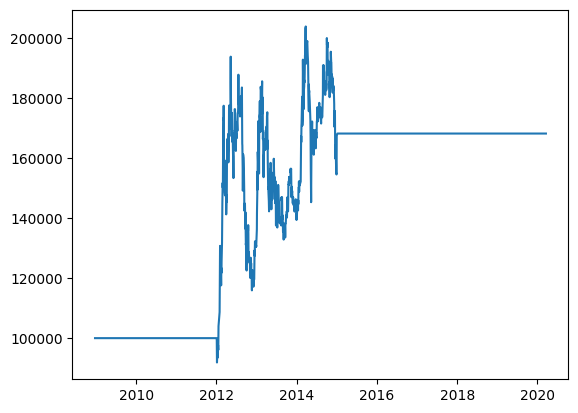

In [25]:
#Biểu đồ biến động vốn
plt.plot(stats._values[-2]['Equity'])

## 🌟 Technical Analysis (EMA) ✅



Sharpe ratio: -0.79
Maximum drawdown: -349.07%
Win rate: 45.48%
Calmar ratio: 0.05
Annual volatility: 38.83%
Annual return: 16.83%
Buy and hold return: -78.56%
Maximum drawdown duration: 2047 days
Maximum trade duration: 2799 days
Duration: 4104 days


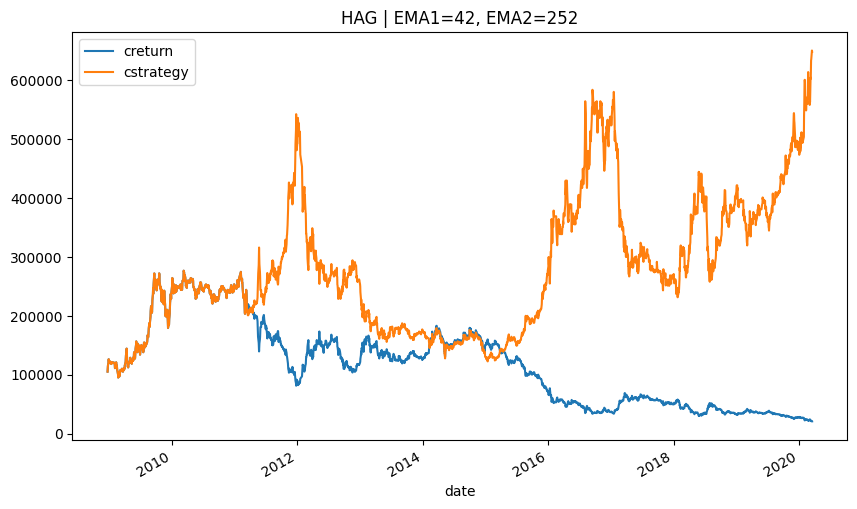

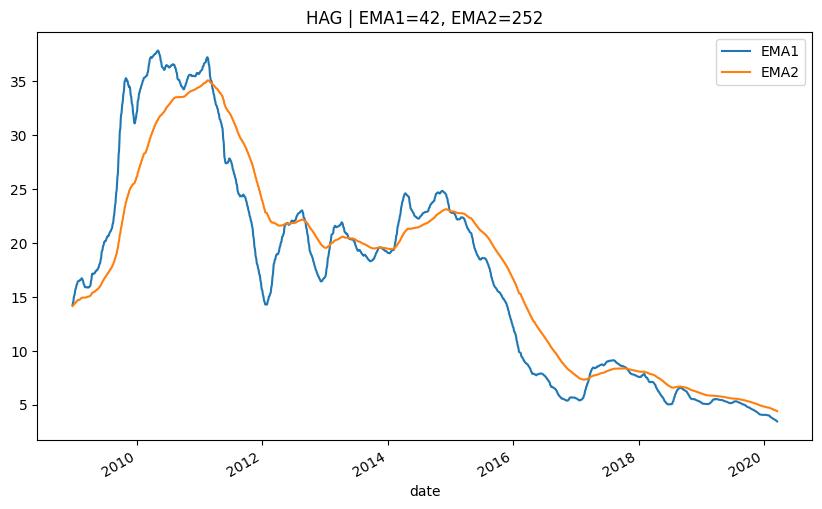

In [26]:
import numpy as np
import pandas as pd

class EMAVectorBacktester(object):
    def __init__(self, symbol, price, EMA1, EMA2, start, end, amount):
        self.symbol=symbol
        self.price = price
        self.EMA1 = EMA1
        self.EMA2 = EMA2
        self.start = start
        self.end = end
        self.amount=amount
        self.get_data()

    def get_data(self):
        raw = pd.read_csv(r'https://raw.githubusercontent.com/Dangvinh777/dataticket/main/hag.csv', index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.price])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.price: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        raw['EMA1'] = raw['price'].ewm(span=self.EMA1, adjust=False).mean()
        raw['EMA2'] = raw['price'].ewm(span=self.EMA2, adjust=False).mean()
        self.data = raw

    def set_parameters(self, EMA1=None, EMA2=None):
        if EMA1 is not None:
            self.EMA1 = EMA1
            self.data['EMA1'] = self.data['price'].ewm(span=self.EMA1, adjust=False).mean()
        if EMA2 is not None:
            self.EMA2 = EMA2
            self.data['EMA2'] = self.data['price'].ewm(span=self.EMA2, adjust=False).mean()

    def run_strategy(self, EMA1=None, EMA2=None):
        data = self.data.copy().dropna()
        data['position'] = np.where(data['EMA1'] > data['EMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturn'] = data['return'].cumsum().apply(np.exp) * self.amount
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp) * self.amount
        self.results = data
        aperf = data['cstrategy'].iloc[-1]
        operf = aperf - data['return'].iloc[-1]

    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | EMA1=%d, EMA2=%d' % (self.symbol, self.EMA1, self.EMA2)
        self.results[['creturn', 'cstrategy']].plot(title=title, figsize=(10, 6))
        self.results[['EMA1', 'EMA2']].plot(title=title, figsize=(10, 6))


    def calculate_sharpe_ratio(self, risk_free_rate):
        excess_returns = self.results['strategy'] - risk_free_rate
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
        return sharpe_ratio

    def calculate_maximum_drawdown(self):
        cum_returns = np.cumprod(1 + self.results["strategy"]) - 1
        running_max = np.maximum.accumulate(cum_returns)
        drawdowns = cum_returns - running_max
        max_drawdown = drawdowns.min()
        return max_drawdown

    def calculate_win_rate(self):
        # Calculate the number of winning trades
        winning_trades = (self.results["strategy"] > 0).sum()
        # Calculate the total number of trades
        total_trades = len(self.results)
        win_rate = winning_trades / total_trades
        return win_rate

    def calculate_calmar_ratio(self):
        annual_rate_of_return = np.mean(self.results["strategy"]) * 252
        max_drawdown = self.calculate_maximum_drawdown()
        calmar_ratio = annual_rate_of_return / abs(max_drawdown)
        return calmar_ratio

    def calculate_annual_volatility(self):
        daily_volatility = np.std(self.results["strategy"])
        annual_volatility = daily_volatility * np.sqrt(252)
        return annual_volatility

    def calculate_annual_return(self):
        daily_return = np.mean(self.results["strategy"])
        annual_return = daily_return * 252
        return annual_return

    def calculate_buy_and_hold_return(self):
        initial_price = self.data["price"].iloc[0]
        final_price = self.data["price"].iloc[-1]
        buy_and_hold_return = (final_price - initial_price) / initial_price
        return buy_and_hold_return

    def calculate_maximum_drawdown_duration(self):
        cum_returns = np.cumprod(1 + self.results["strategy"]) - 1
        running_max = np.maximum.accumulate(cum_returns)
        drawdown_periods = cum_returns < running_max
        drawdown_durations = pd.Series(drawdown_periods).groupby((drawdown_periods != drawdown_periods.shift()).cumsum()).cumsum()
        max_drawdown_duration = drawdown_durations.max()
        return max_drawdown_duration

    def calculate_maximum_trade_duration(self):
        position_periods = (self.results["position"] != 0)
        position_durations = pd.Series(position_periods).groupby((position_periods != position_periods.shift()).cumsum()).cumsum()
        max_trade_duration = position_durations.max()
        return max_trade_duration

    def calculate_duration(self):
        duration_days = (self.data.index[-1] - self.data.index[0]).days
        return duration_days

if __name__ == '__main__':
    emabt = EMAVectorBacktester(symbol='HAG', price='close', EMA1=42, EMA2=252,
                                start='2008-12-22' , end='2020-03-18', amount=100000)
    emabt.run_strategy(EMA1=42, EMA2=252)
    emabt.plot_results()

    sharpe_ratio = emabt.calculate_sharpe_ratio(risk_free_rate=0.02)
    print(f"Sharpe ratio: {sharpe_ratio:.2f}")

    max_drawdown = emabt.calculate_maximum_drawdown()
    print(f"Maximum drawdown: {max_drawdown:.2%}")

    win_rate = emabt.calculate_win_rate()
    print(f"Win rate: {win_rate:.2%}")

    calmar_ratio = emabt.calculate_calmar_ratio()
    print(f"Calmar ratio: {calmar_ratio:.2f}")

    annual_volatility = emabt.calculate_annual_volatility()
    print(f"Annual volatility: {annual_volatility:.2%}")

    annual_return = emabt.calculate_annual_return()
    print(f"Annual return: {annual_return:.2%}")

    buy_and_hold_return = emabt.calculate_buy_and_hold_return()
    print(f"Buy and hold return: {buy_and_hold_return:.2%}")

    max_drawdown_duration = emabt.calculate_maximum_drawdown_duration()
    print(f"Maximum drawdown duration: {max_drawdown_duration} days")

    max_trade_duration = emabt.calculate_maximum_trade_duration()
    print(f'Maximum trade duration: {max_trade_duration} days')

    duration_days = emabt.calculate_duration()
    print(f'Duration: {duration_days} days')

Chiến lược EMA. Cho ra kết quả tương tự với tỉ lệ thua lỗ lên đến 300%, giá trị nắm giữ tuột mất 78%. Biến dộng ở mức chấp nhận được với chỉ hơn 30%, nếu xét về mặt giá thì không cao. Giao dịch với mốc xấp xỉ 2800 ngày, số ngày thắng thì rơi vào loanh quanh 700 ngày, vè cơ bản mô hình EMA vẫn cho lại mức lợi nhuạn vượt thị trường 16% có thể được thể hiện qua biểu đồ.


## 🌟 Technical Analysis (SMA) ✅


(259750.44, 250088.45)
(259750.44, 250088.45)
(array([ 42., 244.]), 360317.01)
Sharpe ratio: -0.82
Maximum drawdown: -200.84%
Win rate: 45.91%
Calmar ratio: 0.06
Annual volatility: 37.84%
Annual return: 12.63%
Buy and hold return: -78.56%
Maximum drawdown duration: 2047 days
Maximum trade duration: 2557 days
Duration: 4104 days


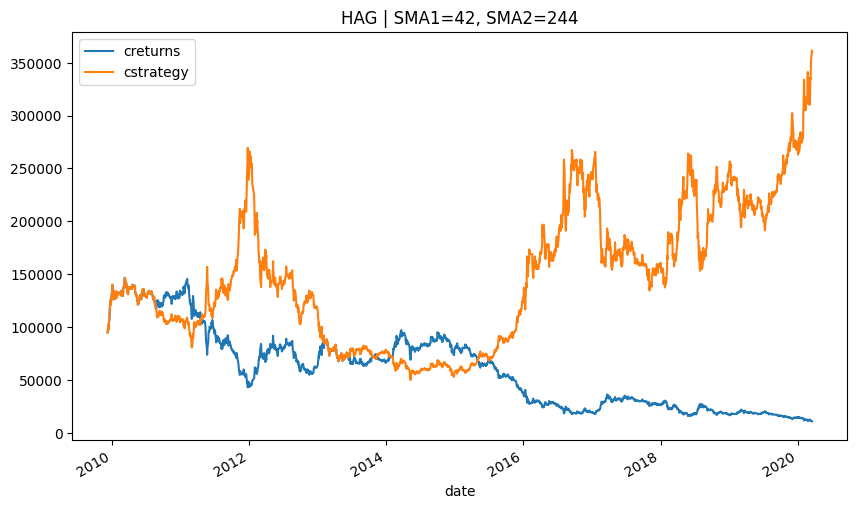

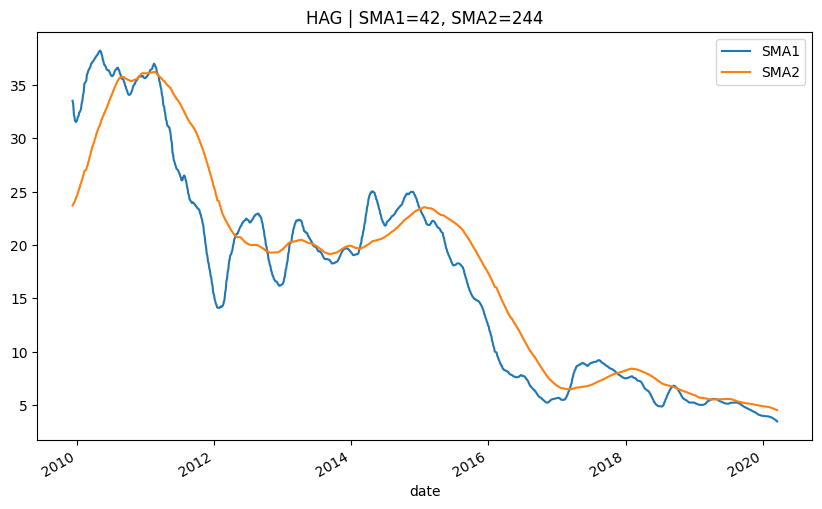

In [27]:
import numpy as np
import pandas as pd
from scipy.optimize import brute


class SMAVectorBacktester(object):

    def __init__(self, SMA1, SMA2, price, start, end, amount):
        self.price = price
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.amount=amount
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('https://raw.githubusercontent.com/Dangvinh777/dataticket/main/hag.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.price])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.price: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['price'].rolling(self.SMA1).mean()
        raw['SMA2'] = raw['price'].rolling(self.SMA2).mean()
        self.data = raw
    def set_parameters(self, SMA1=None, SMA2=None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()

    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp) * self.amount
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp) * self.amount
        self.results = data
        # gross performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = 'HAG | SMA1=%d, SMA2=%d' % (self.SMA1, self.SMA2)
        self.results[['creturns', 'cstrategy']].plot(title=title,figsize=(10, 6))
        self.results[['SMA1', 'SMA2']].plot(title=title, figsize=(10, 6))

    def update_and_run(self, SMA):
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

    def calculate_sharpe_ratio(self, risk_free_rate):
        excess_returns = self.results['strategy'] - risk_free_rate
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
        return sharpe_ratio

    def calculate_maximum_drawdown(self):
        cum_returns = np.cumprod(1 + self.results["strategy"]) - 1
        running_max = np.maximum.accumulate(cum_returns)
        drawdowns = cum_returns - running_max
        max_drawdown = drawdowns.min()
        return max_drawdown

    def calculate_win_rate(self):
        # Calculate the number of winning trades
        winning_trades = (self.results["strategy"] > 0).sum()
        # Calculate the total number of trades
        total_trades = len(self.results)
        win_rate = winning_trades / total_trades
        return win_rate

    def calculate_calmar_ratio(self):
        annual_rate_of_return = np.mean(self.results["strategy"]) * 252
        max_drawdown = self.calculate_maximum_drawdown()
        calmar_ratio = annual_rate_of_return / abs(max_drawdown)
        return calmar_ratio

    def calculate_annual_volatility(self):
        daily_volatility = np.std(self.results["strategy"])
        annual_volatility = daily_volatility * np.sqrt(252)
        return annual_volatility

    def calculate_annual_return(self):
        daily_return = np.mean(self.results["strategy"])
        annual_return = daily_return * 252
        return annual_return

    def calculate_buy_and_hold_return(self):
        initial_price = self.data["price"].iloc[0]
        final_price = self.data["price"].iloc[-1]
        buy_and_hold_return = (final_price - initial_price) / initial_price
        return buy_and_hold_return

    def calculate_maximum_drawdown_duration(self):
        cum_returns = np.cumprod(1 + self.results["strategy"]) - 1
        running_max = np.maximum.accumulate(cum_returns)
        drawdown_periods = cum_returns < running_max
        drawdown_durations = pd.Series(drawdown_periods).groupby((drawdown_periods != drawdown_periods.shift()).cumsum()).cumsum()
        max_drawdown_duration = drawdown_durations.max()
        return max_drawdown_duration

    def calculate_maximum_trade_duration(self):
        position_periods = (self.results["position"] != 0)
        position_durations = pd.Series(position_periods).groupby((position_periods != position_periods.shift()).cumsum()).cumsum()
        max_trade_duration = position_durations.max()
        return max_trade_duration

    def calculate_duration(self):
        duration_days = (self.data.index[-1] - self.data.index[0]).days
        return duration_days

if __name__ == '__main__':
    smabt = SMAVectorBacktester(SMA1=42, SMA2=252, price='close',
                                start='2008-12-22' , end='2020-03-18', amount=100000)
    print(smabt.run_strategy())
    #EMA12=smabt.set_parameters(SMA1=42, SMA2=252)
    print(smabt.run_strategy())
    print(smabt.optimize_parameters((30, 56, 4), (200, 300, 4)))
    smabt.plot_results()

    sharpe_ratio = smabt.calculate_sharpe_ratio(risk_free_rate=0.02)
    print(f"Sharpe ratio: {sharpe_ratio:.2f}")

    max_drawdown = smabt.calculate_maximum_drawdown()
    print(f"Maximum drawdown: {max_drawdown:.2%}")

    win_rate = smabt.calculate_win_rate()
    print(f"Win rate: {win_rate:.2%}")

    calmar_ratio = smabt.calculate_calmar_ratio()
    print(f"Calmar ratio: {calmar_ratio:.2f}")

    annual_volatility = smabt.calculate_annual_volatility()
    print(f"Annual volatility: {annual_volatility:.2%}")

    annual_return = smabt.calculate_annual_return()
    print(f"Annual return: {annual_return:.2%}")

    buy_and_hold_return = smabt.calculate_buy_and_hold_return()
    print(f"Buy and hold return: {buy_and_hold_return:.2%}")

    max_drawdown_duration = smabt.calculate_maximum_drawdown_duration()
    print(f"Maximum drawdown duration: {max_drawdown_duration} days")

    max_trade_duration = smabt.calculate_maximum_trade_duration()
    print(f'Maximum trade duration: {max_trade_duration} days')

    duration_days = smabt.calculate_duration()
    print(f'Duration: {duration_days} days')

Với chiến lược SMA, và tối ưu hóa SMA. Cho ra kết quả. Lợi nhuận chỉ đạt ngưỡng 13%, biến động duy trì ở mức cao với hơn 30%, nhưng sử dụng chiến lược này cho tỷ lệ thắng khá cao với xấp xỉ 45%, mặc dùng trên các chỉ số xét đoán. Tỷ lệ thua lỗ tối đa lên đến 200%, một con số không tưởng, để rồi đến khi kết thúc thì chỉ thu về một ít lợi nhuận. Mô hình giao dịch rất nhiều trên 2500 ngày, có thể thấy lợi nhuận thu về rất nhỏ sau mỗi lần giao dịch, lũy kế lên chỉ mới đạt được ngưỡng như trên, cùng với đó nhằm củng cố ý kiến nêu trên còn có chỉ số thua lỗ với xấp xỉ 2000 ngày. Tức là số ngày thắng chỉ rơi vào hơn 500 ngày, một con số vô cùng khiêm tốn, chứng tỏ cổ phiếu HAG là dạng cổ phiếu rất rủi ro khi đầu tư vào, cùng với đó sau khi chấm dứt hoạt động ở mảng BĐS thì cổ phiếu gần như tụt không phanh, kéo theo số ngày SMA ngắn hạn vượt dài hạn cũng giảm theo.


## 🌟 VNindex ✅

In [28]:
df_vnindex=pd.read_csv("https://raw.githubusercontent.com/Dangvinh777/dataticket/main/vnindex_stock.csv")
df_vnindex

,ticker,date,open,high,low,close,volume
0,vnindex,2019-11-15,1012.93,1015.16,1005.10,1010.03,212329658
1,vnindex,2019-11-14,1014.14,1016.34,1010.60,1012.30,209404256
2,vnindex,2019-11-13,1019.07,1020.09,1010.89,1012.77,286967681
3,vnindex,2019-11-12,1016.97,1021.84,1015.97,1018.33,223157118
4,vnindex,2019-11-11,1023.32,1024.77,1016.35,1016.75,210430901
...,...,...,...,...,...,...,...
4641,vnindex,2000-08-07,106.92,106.92,106.92,106.92,13200
4642,vnindex,2000-08-04,105.20,105.20,105.20,105.20,3800
4643,vnindex,2000-08-02,103.38,103.38,103.38,103.38,300
4644,vnindex,2000-07-31,101.55,101.55,101.55,101.55,10300


In [29]:
# Chuyển cột dữ liệu về ngày giao dịch thành đối tượng kiểu datetime
df_vnindex['Date'] = pd.to_datetime(df_vnindex['date'])

# Đặt cột Date làm chỉ mục (index) của DataFrame
df_vnindex = df_vnindex.set_index('Date')

# Tính toán lợi nhuận hàng ngày của VNIndex
df_vnindex['Daily Return'] = (df_vnindex['close'] - df_vnindex['close'].shift(1)) / df_vnindex['close'].shift(1)

# Xóa các dòng chứa giá trị NaN
df_vnindex = df_vnindex.dropna()

# Tính lợi nhuận hàng năm của VNIndex
annual_return = df_vnindex['Daily Return'].mean()*252*100

print("Lợi nhuận hàng năm của VNIndex là:", annual_return, "%")

Lợi nhuận hàng năm của VNIndex là: -9.733855005450001 %


In [30]:
# Chuyển đổi cột 'Date' sang định dạng ngày tháng
df_vnindex['date'] = pd.to_datetime(df_vnindex['date'], format='%Y-%m-%d')

# Thiết lập cột 'Date' làm chỉ mục của DataFrame
df_vnindex.set_index('date', inplace=True)

# Tính toán tỉ lệ lợi nhuận trung bình hàng ngày
daily_returns = df_vnindex['close'].pct_change()

# Tính toán tỉ lệ lợi nhuận trung bình hàng năm
average_daily_return = daily_returns.mean()
annualized_return = ((1 + average_daily_return) ** 252) - 1

print("Lợi nhuận trung bình hàng năm của VN-Index là:", round(annualized_return*100, 2), "%")

Lợi nhuận trung bình hàng năm của VN-Index là: -9.29 %
